# Creating a QSPR model

## Pre-processing your dataset

### Converting data into the right format
First your dataset needs to be in the right format.
It has to have a least a column containing SMILES sequences, as well as a column for each of the properties you want
to predict, e.g.

| SMILES                             | Bioactivity | 
|------------------------------------|-----------|
| c1cn(c(=O)nc1N)[C@H]2CO[C@H\](S2)CO | 7.0       | 
| [H]N([H])C1(CC1)C(=O)O[H]          | 4.5       | 
| c1c(csc1COc2c3c(nc[nH]3)nc(n2)N)Br | 12.55     |
| ...                                | ...       | 

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load in the data
df = pd.read_csv('data/parkinsons_dp_original.csv', sep=',')

smiles_col = 'SMILES'
activity_col = 'pchembl_value_Mean'
target_col = 'accession'

# combine uniprot accessions of same protein
df = df.loc[df['accession'].isin(['P14867', 'P31644', 'P34903', 'P47869', 'P48169', 'Q16445', 'O15399', 'O60391', 'Q05586', 'Q12879', 'Q13224', 'Q14957', 'Q8TCU5', 'Q14643', 'P41594', 'Q13255'])]
df.loc[df['accession'].isin(['P14867', 'P31644', 'P34903', 'P47869', 'P48169', 'Q16445']), 'accession'] = 'GABAAalpha'
df.loc[df['accession'].isin(['O15399', 'O60391', 'Q05586', 'Q12879', 'Q13224', 'Q14957', 'Q8TCU5']), 'accession'] = 'NMDA'

# drop columns without pchembl value
df = df.dropna(subset=['pchembl_value_Mean'])

# print number of samples per target
print(df[target_col].value_counts())

# Get data in correct format and taking the mean if multiple activatie values per smiles
df = df.pivot_table(index=[smiles_col], columns=[target_col], values=activity_col, aggfunc=np.mean).reset_index()
df.to_csv('data/parkinsons_pivot.tsv', sep='\t', index=False)
display(df.head(5))
display(df.shape)

GABAAalpha    6280
NMDA          4073
P41594        2730
Q13255         975
Q14643          12
Name: accession, dtype: int64


accession,SMILES,GABAAalpha,NMDA,P41594,Q13255,Q14643
0,Brc1cc(-c2nc(-c3ncccc3)no2)ccc1,NaN,NaN,6.93,NaN,NaN
1,Brc1ccc2c(c1)-c1ncnn1Cc1c(-c3cccs3)ncn-21,8.400000,NaN,NaN,NaN,NaN
2,Brc1ccc2c(c1)-c1nncn1Cc1c(I)ncn-21,8.110000,NaN,NaN,NaN,NaN
3,Brc1cccc(-c2cc(-c3ccccc3)nnc2)c1,8.013333,NaN,NaN,NaN,NaN
4,Brc1cccc(-c2cnnc(NCc3ccccc3)c2)c1,7.505000,NaN,NaN,NaN,NaN


(6225, 6)

### Preparing the data for modelling with QSPRpred

We will built a regression model for the GABA(A) receptor subunit alpha (GABAAalpha).
Therefore, we initialize our QSPRdataset as regression for "GABAAalpha".
After this we need to do some processing of the data.
We need to calculate compound features, split our dataset into a train and test set.

In [2]:
import os
from qsprpred.data.data import QSPRDataset
from qsprpred.data.utils.descriptorsets import MorganFP
from qsprpred.data.utils.descriptorcalculator import descriptorsCalculator
from sklearn.preprocessing import StandardScaler as Scaler
from qsprpred.data.utils.datasplitters import randomsplit

# intialize the dataset
dataset = QSPRDataset(df=df, smilescol=smiles_col, property="GABAAalpha", reg=True)

# create folder to save models
if not os.path.isdir('qspr/data'):
    os.makedirs('qspr/data')
if not os.path.isdir('qspr/models'):
    os.mkdir('qspr/models')

# Calculate MorganFP and physicochemical properties
feature_calculators = descriptorsCalculator(descsets = [MorganFP(3, 2048)])
feature_calculators.toFile(fname='qspr/data/REG_GABAAalpha_DescCalc.json')

# Do a random split for creating the train (85%) and test set (15%)
rand_split = randomsplit(0.15)


# calculate compound features and split dataset into train and test
dataset.prepareDataset(f"qspr/data/REG_GABAAalpha_DescCalc.json",
                    split=rand_split,
                    feature_calculators=feature_calculators,
                    feature_standardizers=[Scaler()]
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}")

Number of samples train set: 1742
Number of samples test set: 308


## Training the QSPR model

After preparing our dataset, we will train a QSPR regression model.
In this tutorial we will train a XGBoost model as it generally performs well, but there are other model types
available. Most machine learning models have tunable hyperparameters (for example depth & learning rate), as some hyperparameter combinations will lead to better performance on a task we perform hyperparameter optimization (in which different combinations are tested and evaluated on a subset of the training data). After finding good hyperparameters a model will be trained on the training data & evaluated on the test data. In addition to this the final model will be trained on all data

In [3]:
from qsprpred.models.models import QSPRsklearn
from sklearn.cross_decomposition import PLSRegression

# This is an SKlearn model, so we will initialize it with the QSPRsklearn class
model = QSPRsklearn(base_dir = '.',
                        data=dataset, alg = PLSRegression(), alg_name='PLS', n_jobs=3)

# We will first optimize the hyperparameters (n_components and scale) through bayes optimization
# the best hyperparameter combination will be saved in PLS_REG_GABAAalpha_params.json
search_space_bs = {"n_components": ["int", 1, 20], "scale": ["categorical", [True, False]]}
model.bayesOptimization(search_space_bs=search_space_bs, n_trials=5)

#Then we will evaluate the performance of the best model using the independent test set
_ = model.evaluate()

# Finally, we need to fit the model on the complete dataset if we want to use it further
# model is saved under qsprmodels/PLS_REG_GABAAalpha.pkg
model.fit()


[I 2022-11-28 16:14:10,581] A new study created in memory with name: no-name-78d39409-9ce4-4f30-b128-b9e113ce017a


Bayesian optimization can take a while for some hyperparameter combinations
{'n_components': 4, 'scale': True}


[I 2022-11-28 16:14:11,554] Trial 0 finished with value: 0.634556882466055 and parameters: {'n_components': 4, 'scale': True}. Best is trial 0 with value: 0.634556882466055.


{'n_components': 15, 'scale': True}


[I 2022-11-28 16:14:13,844] Trial 1 finished with value: 0.49151539384044796 and parameters: {'n_components': 15, 'scale': True}. Best is trial 0 with value: 0.634556882466055.


{'n_components': 16, 'scale': False}


[I 2022-11-28 16:14:16,156] Trial 2 finished with value: 0.47740645506544166 and parameters: {'n_components': 16, 'scale': False}. Best is trial 0 with value: 0.634556882466055.


{'n_components': 2, 'scale': True}


[I 2022-11-28 16:14:16,882] Trial 3 finished with value: 0.5772490428198374 and parameters: {'n_components': 2, 'scale': True}. Best is trial 0 with value: 0.634556882466055.


{'n_components': 15, 'scale': True}


[I 2022-11-28 16:14:19,166] Trial 4 finished with value: 0.49151539384044796 and parameters: {'n_components': 15, 'scale': True}. Best is trial 0 with value: 0.634556882466055.


## Evaluating the results

Plotting the results of our model on the test set we can see that it is performing well.

PLS Cross Validation:  :(R^2=0.63, RMSE=0.82)
PLS Independent Test::(R^2=0.66, RMSE=0.80)


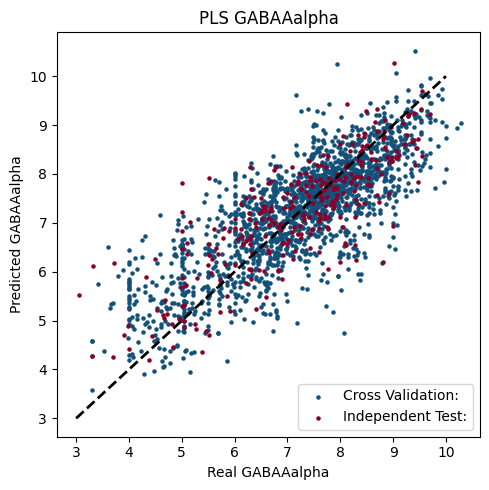

In [4]:
from matplotlib import pyplot as plt
from sklearn import metrics

def QSPR_REG_scatterplot(infolder, targets, models, out=None):
    """
    Function to plot the results of regression models. Plot predicted pX vs real pX. 
    """
    my_cmap = ["#12517B", "#88002A"]

    plt.figure(figsize=(5, 5))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        for m, model in enumerate(models):
            plt.subplot(len(targets),len(models),1 + i*len(models) + m)
            for j, legend in enumerate(['Cross Validation:  ', 'Independent Test:']):
                df = pd.read_table('%s/%s_REG_%s.%s.tsv' % (infolder, model, target, cate[j]))
                plt.scatter(df.Label, df.Score, s=5, label=legend, color=my_cmap[j])
                coef = metrics.r2_score(df.Label, df.Score)
                rmse = metrics.mean_squared_error(df.Label, df.Score, squared=False)
                print('%s %s:(R^2=%.2f, RMSE=%.2f)' % (model, legend,coef,rmse))

            plt.title('%s %s' % (model,target))
            plt.xlabel(f"Real {target}")
            plt.ylabel(f"Predicted {target}")
            plt.plot([3, 10], [3, 10], lw=2, linestyle='--', color='black')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.3, hspace = 0.5) 
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300)

# create folder for figures
if not os.path.isdir('figures'):
    os.mkdir('figures')

QSPR_REG_scatterplot(f"qspr/models",
                     ["GABAAalpha"], 
                     ["PLS"],
                      out="figures/qsprmodels_GABAAalpha.png")